In [ ]:
!pip install mpld3
import mpld3


from mpld3 import plugins

Se define una clase robot

In [2]:
import numpy as np

import threading
import time
import timeit

from clase_PID import PID
from clase_PID import calculate_references

# from reference_generator import ref_generator

class Robot():
    def __init__(self,x=0,y=0,theta=0,dt = 0.1, dt_control = 0.5):
        
        # posición real del robot
        self.__ground_truth = (x,y,theta)
        self.__odometry = (x,y,theta)


		# dimensiones del robot
        self.r = 0.036
        self.l = 0.235
        self.height = 0.10
        self.diameter = 0.35

		# velocidades del robot
        self.__v = 0
        self.__w = 0
        
        # velocidades máximas y mínimas
        self.__v_max = 2.0
        self.__v_min = -2.0
        #self.__v_max = 1000
        #self.__v_min = -1000
         
        # velocidades máximas y mínimas
        self.__w_max = 5.0
        self.__w_min = -5.0
        #self.__w_max = 1000
        #self.__w_min = -1000

		#Error parameters
		# self.alpha = (0.10, 0.20, 0.10, 0.20, 0.25, 0.25)
        alpha = [0.10, 0.20, 0.10, 0.20, 0.25, 0.25]
        multiplicador = 2
        alpha = [a * multiplicador for a in alpha]
        self.alpha = tuple(alpha)
        
        # configuración del simulador del robot móvil
        self.__simulation_mobile_robot_on = False # indica si la simulación está corriendo o no
        self.__simulation_mobile_robot_thread = threading.Thread(target = self.__simulation_task_mobile_robot)
        self.dt = dt
        
        
        # configuración del simulador del controlador
        self.__simulation_control_on = False
        self.__simulation_control_thread = threading.Thread(target = self.__simulation_task_control)
        self.dt_control = dt_control
        self.__step_counter_control = 0
        
	# setters
	# setear la velocidad lineal
    def set_linear_velocity(self,v):
        if(v > self.__v_max):
            self.__v = self.__v_max
        elif(v < self.__v_min):
            self.__v = self.__v_min
        else:
            self.__v = v

	# setear la velocidad angular
    def set_angular_velocity(self,w):
        if(w > self.__w_max):
            self.__w = self.__w_max
        elif(w < self.__w_min):
            self.__w = self.__w_min
        else:
            self.__w = w
    
    # getters
	# obtener la velocidad lineal
    def get_linear_velocity(self):
        return self.__v

	# obtener la velocidad angular
    def get_angular_velocity(self):
        return self.__w

	# obtener el ground truth del robot
    def get_ground_truth(self):
        return self.__ground_truth
    
    def get_odometry(self):
        return self.__odometry
    
    def get_real_trajectory(self):
        return self.__real_trajectory
    
    #private methods
    def __sample_nd(self, b):
        return (b / 6.0) * np.sum(2.0 * np.random.rand(12) - 1.0)

	# movimiento del robot
    def move(self):
        
        v = self.__v
        w = self.__w

        if(w != 0):
            v_w = v/w
            next_x = self.__odometry[0] - v_w * np.sin(self.__odometry[2]) + v_w * np.sin(self.__odometry[2] + w * self.dt)
            next_y = self.__odometry[1] + v_w * np.cos(self.__odometry[2]) - v_w * np.cos(self.__odometry[2] + w * self.dt)
            next_theta = self.__odometry[2] + w * self.dt

        else:
            next_x = self.__odometry[0] + v * np.cos(self.__odometry[2]) * self.dt
            next_y = self.__odometry[1] + v * np.sin(self.__odometry[2]) * self.dt
            next_theta = self.__odometry[2]
		
        next_odom = (next_x,next_y,next_theta)
        self.__odometry = next_odom
        
        v_hat = v + self.__sample_nd(self.alpha[0] * np.abs(v) + self.alpha[1] * np.abs(w))
        w_hat = w + self.__sample_nd(self.alpha[2] * np.abs(v) + self.alpha[3] * np.abs(w))
        gamma_hat = self.__sample_nd(self.alpha[4] * np.abs(v) + self.alpha[5] * np.abs(w))
        
        if(w_hat != 0):
            v_w = v_hat/w_hat
            next_x = self.__ground_truth[0] - v_w * np.sin(self.__ground_truth[2]) + v_w * np.sin(self.__ground_truth[2] + w_hat * self.dt)
            next_y = self.__ground_truth[1] + v_w * np.cos(self.__ground_truth[2]) - v_w * np.cos(self.__ground_truth[2] + w_hat * self.dt)
            next_theta = self.__ground_truth[2] + w_hat * self.dt + gamma_hat * self.dt

        else:
            next_x = self.__ground_truth[0] + v_hat * np.cos(self.__ground_truth[2]) * self.dt
            next_y = self.__ground_truth[1] + v_hat * np.sin(self.__ground_truth[2]) * self.dt
            next_theta = self.__ground_truth[2] + gamma_hat * self.dt

		# se normaliza la orientación del robot, para obtener un número entre -pi y pi
        while(next_theta > np.pi):
            next_theta = next_theta - 2 * np.pi

        while(next_theta <= -np.pi):
            next_theta = next_theta + 2 * np.pi


		# se setea la nueva pose del robot
        next_pos = (next_x,next_y,next_theta)

        self.__ground_truth = next_pos
        
# Métodos del trajectory follower

# Configuración del seguidor de trayectorias
    #def trajectory_follow_config(self,Kp,Ti,Td,trajectory):
    def trajectory_follow_config(self,Kp_s,Kp_theta,trajectory):
        
        # se crea el generador de referencias que se utilizará para
        # controlar la trayectoria
        # self.ref_gen = ref_generator()
        
        # se crean los PIDs para el seguimiento de trayectoria
        self.PID_theta = PID(Kp_theta,0,0,self.dt_control)
        self.PID_s = PID(Kp_s,0,0,self.dt_control)
        
        # se carga la trayectoria a seguir
        self.trajectory = trajectory
        self.trajectory_len = np.shape(trajectory)[1]
        
        # se setea la primer referencia
        self.n_ref = 0
        self.reference = trajectory[:,self.n_ref]
        
        # contador que sirve para saber cuándo modificar la referencia del
        # controlador
        self.reference_change_counter = 0
        self.reference_change_counter_max = 3
        
        self.trajectory_follow_activated = False
        
        # se crea una lista vacía que contendrá todas las poses de las 
        # trayectorias que irá recorriend el robot
        self.__real_trajectory = []
        
# Cálculo de la acción de control del seguidor de trayectorias        
    def trajectory_follow(self):
        
        # Se calculan las referencias auxiliares
        # aux_reference = self.ref_gen.get_reference(self.trajectory,self.n_ref,self.__ground_truth) 
        
        aux_reference = self.reference

        
        #aux_reference = np.array(aux_reference)
        #aux_reference.shape = (2,1)
        
        # A partir de la referencia en la trayectoria y de la posición actual,
        # se calculan los errores
        # e_theta, e_s = calculate_references(self.reference,self.__ground_truth)
        e_theta, e_s = calculate_references(aux_reference,self.__ground_truth)
        
        # Se calculan las velocidades lineal y angular
        w = self.PID_theta.control(e_theta)
        v = self.PID_s.control(e_s)
        
        # Se setean en el robot
        self.set_linear_velocity(v)
        self.set_angular_velocity(w)
        
        self.reference_change_counter +=1
        
        if self.reference_change_counter == self.reference_change_counter_max:
            # se setea la próxima referencia
            self.n_ref = self.n_ref + 1
            self.reference_change_counter = 0
            self.__real_trajectory.append(self.__ground_truth)
        
            if self.n_ref < self.trajectory_len:
                self.reference = self.trajectory[:,self.n_ref]
            
            else:
                self.trajectory_follow_activated = False

# =============================================================================
# Métodos de la simulación
# =============================================================================
# Simulation task: ejecuta el paso de simulación del robot móvil
    def __simulation_task_mobile_robot(self):
        
        while self.__simulation_mobile_robot_on == True:
            
            # se incrementa en uno el contador de veces que se invocó al
            # paso de simulación de control
            self.__step_counter_mobile_robot += 1
            
            # tiempo que tarda en ejecutarse la función que mueve al robot            
            time_for_moving = timeit.timeit(self.move, number = 1)
            
            time_to_sleep = self.dt - time_for_moving
            
            if time_to_sleep > 0:
                time.sleep(time_to_sleep)
                
            else:
                time.sleep(0.010)
        
        return

# Simulation task: ejectua el controlador para calcular la velocidad lineal y
# angular del robot
    def __simulation_task_control(self):
        
        while self.__simulation_control_on == True:
            
            self.__step_counter_control += 1
            
            # tiempo que tarda en ejecutarse la función que mueve al robot
            time_for_controlling = timeit.timeit(self.trajectory_follow, number = 1)
            
            time_to_sleep = self.dt_control - time_for_controlling
            
            if time_to_sleep > 0:
                time.sleep(time_to_sleep)
            
            else:
                time.sleep(0.010)
        
        return

    # Simulation start: inicial as imulación del movimiento del robot
    def start_simulation_robot(self):
        
        self.__step_counter_mobile_robot = 0
        self.__elapsed_time_mobile_robot = 0
        self.__simulation_mobile_robot_on = True
        self.__simulation_mobile_robot_thread.start()
    
    def stop_simulation_robot(self):
        
        self.__simulation_mobile_robot_on = False
        self.__simulation_mobile_robot_thread.join()
        print("Robot: simulation stopped")
    
    # Simulation start: inicial as imulación del movimiento del trajectory follow
    def start_simulation_control(self):
        
        self.__step_counter_control = 0
        self.__elapsed_time_control = 0
        self.__simulation_control_on = True
        self.trajectory_follow_activated = True
        self.__simulation_control_thread.start()
    
    def stop_simulation_control(self):
        
        self.__simulation_control_on = False
        self.__simulation_control_thread.join()
        print("Control: simulation stopped")

# Simulation start:inicia la simulación de todo
    def start_simulation(self):
            
        self.start_simulation_robot()
        self.start_simulation_control()

# Stop simulation: detiene la simulación de todo
    def stop_simulation(self):
        
        if self.__simulation_mobile_robot_on == True:
            self.stop_simulation_robot()
            
        if self.__simulation_control_on == True:
            self.stop_simulation_control()

# Devuelve el contador de la simulación del robot móvil
    def get_simulation_step_counter_mobile_robot(self):
        return self.__step_counter_mobile_robot

# Devuelve el tiempo de la simulación del robot móvil
    def get_simulation_time_mobile_robot(self):
        return self.__step_counter_mobile_robot * self.dt

# Devuelve el contador de la simulación del controlador
    def get_simulation_step_counter_control(self):
        return self.__step_counter_control

# Devuelve el tiempo de la simulación del robot controlador
    def get_simulation_time_control(self):
        return self.__step_counter_control * self.dt_control
    

In [5]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from ploteo_del_robot import *
from curve_equally_spaced import *

import pdb

In [6]:
# Utilidades
import numpy as np

def length_trajectory(T):
    
    N = T.shape[1]
    
    l = 0
    
    for i in range(1,N):
        
        t1 = T[:,i]
        t0 = T[:,i-1]

        delta_l = np.linalg.norm(t1 - t0)
        
        l += delta_l
    
    return l

def calculate_error(c,d):
    # c: np.array de 2 x N, trayectoria real
    # d: np.array de 2 x N, trayectoria deseada
    N = np.shape(d)[1]
    e = 0
    e_peak = 0
    for i in range(N):
        c_aux = np.array(c[i][0:2])
        # c_aux.shape = (2,1)
        e_new = np.linalg.norm(c_aux - d[:,i])
        
        if(e_new > e_peak):
            e_peak = e_new
            
        e = e + e_new**2
        # e_peak
    
    e = e / N
    
    e_rms = np.sqrt(e)
    
    return e_rms, e_peak
        
        
def create_trajectory(N):
    
    # trayectoria lineal
    # return linear_trajectory(N)
    
    # trayectoria circunferencia
    # return circle_trajectory(N)
    # return square_trajectory(N)
    # return square_trajectory_y(N)
    # return training_trajectory(N)
    # return labyrinth_trajectory(N)
    return spiral_trajectory(N)
    # return spiral_trajectory_2(N)
    # return long_training_trajectory(N)
    # return long_training_trajectory_2(N)
    # return curvy_trajectory(N)
    
def linear_trajectory(N):
    # devuelve un array de posiciones (x,y) que definen la trayectoria a seguir
    # la trayectoria será de N puntos en el plano
    trajectory_x = np.linspace(0,30,N)
    trajectory_y = np.ones(trajectory_x.shape) * 0
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    return trajectory

def circle_trajectory(N):
    radio = 44
    center = np.array([44,44])
    angle = np.linspace(0,2*np.pi,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle)
    trajectory = np.stack((trajectory_x,trajectory_y))

    return trajectory

def square_trajectory(N):
    
    n = int(N/4)
    #diff = 10/(n-1)
    lado = 20
    # lado = 10

    p = lado*4 / N
    
    primer_tramo_x = np.arange(0,lado,p)
    primer_tramo_y = np.zeros( np.shape(primer_tramo_x)[0] )

    segundo_tramo_y = np.arange(0,lado,p)
    segundo_tramo_x = np.ones( np.shape(segundo_tramo_y)[0] ) * lado
    
    tercer_tramo_x = np.arange(lado,0,-p)
    tercer_tramo_y = np.ones(np.shape(primer_tramo_x)[0] ) * lado

    cuarto_tramo_y = np.arange(lado,0,-p)
    cuarto_tramo_x = np.zeros( np.shape(cuarto_tramo_y)[0] )
    
    """
    primer_tramo_x = np.linspace(0,lado,n)
    primer_tramo_y = np.zeros(n)

    segundo_tramo_x = np.ones(n) * lado
    segundo_tramo_y = np.linspace(0,lado,n)

    tercer_tramo_x = np.linspace(lado,0,n)
    tercer_tramo_y = np.ones(n) * lado
    
    cuarto_tramo_x = np.zeros(n)
    cuarto_tramo_y = np.linspace(lado,0,n)
    """
    trajectory_x = np.concatenate((primer_tramo_x,segundo_tramo_x,tercer_tramo_x,cuarto_tramo_x))
    trajectory_y = np.concatenate((primer_tramo_y,segundo_tramo_y,tercer_tramo_y,cuarto_tramo_y))
    trajectory = np.stack((trajectory_x,trajectory_y))
    

    return trajectory

def square_trajectory_y(N):
    
    n = int(N/4)
    #diff = 10/(n-1)

    lado = 10
    
    primer_tramo_x = np.zeros(n)
    primer_tramo_y = np.linspace(0,lado,n)
    
    segundo_tramo_x = np.linspace(0,lado,n)
    segundo_tramo_y = np.ones(n) * lado
    
    tercer_tramo_x = np.ones(n) * lado
    tercer_tramo_y = np.linspace(lado,0,n)
    
    cuarto_tramo_x = np.linspace(lado,0,n)
    cuarto_tramo_y = np.zeros(n)
    
    trajectory_x = np.concatenate((primer_tramo_x,segundo_tramo_x,tercer_tramo_x,cuarto_tramo_x))
    trajectory_y = np.concatenate((primer_tramo_y,segundo_tramo_y,tercer_tramo_y,cuarto_tramo_y))
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    return trajectory
    
# Trayectoria larga

def labyrinth_trajectory(N):

  lado_y = 20

  lado_x = 5

  M = 5

  N_aux = N/M

  l = (lado_x + lado_y) * 2

  n_horizontal = int(N_aux * lado_x/l)+1

  n_vertical = int(N_aux * lado_y/l)

  print(n_horizontal,n_vertical)
  # pdb.set_trace()
  # 1era parte vertical
  path_1_x = np.zeros(n_vertical)[0:n_vertical-1]
  path_1_y = np.linspace(0,lado_y,n_vertical)[0:n_vertical-1]

  # 2da parte horizontal
  path_2_x = np.linspace(0,lado_x,n_horizontal)[0:n_horizontal-1]
  path_2_y = ( np.ones(n_horizontal) * lado_y )[0:n_horizontal-1]

  # 3era parte vertical
  path_3_x = ( np.ones(n_vertical) * lado_x )[0:n_vertical-1]
  path_3_y = np.linspace(lado_y,0,n_vertical)[0:n_vertical-1]

  # 4ta parte horizontal
  path_4_x = np.linspace(lado_x,lado_x * 2,n_horizontal)[0:n_horizontal-1]
  path_4_y = np.zeros(n_horizontal)[0:n_horizontal-1]

  trajectory_x = np.concatenate((path_1_x,path_2_x,path_3_x,path_4_x))
  trajectory_y = np.concatenate((path_1_y,path_2_y,path_3_y,path_4_y))

  for i in range(1,M):
    path_1_x = ( np.ones(n_vertical) * lado_x * (2*i) )[0:n_vertical-1]
    path_1_y = np.linspace(0,lado_y,n_vertical)[0:n_vertical-1]

    path_2_x = ( np.linspace(lado_x * (2 * i),lado_x * (2 * i + 1),n_horizontal) )[0:n_horizontal-1]
    path_2_y = ( np.ones(n_horizontal) * lado_y )[0:n_horizontal-1]

    path_3_x = ( np.ones(n_vertical) * lado_x * (2 * i + 1) )[0:n_vertical-1]
    path_3_y = np.linspace(lado_y,0,n_vertical)[0:n_vertical-1]

    path_4_x = ( np.linspace(lado_x * (2 * i + 1),lado_x * (2*i+2),n_horizontal) )[0:n_horizontal-1]
    path_4_y = np.zeros(n_horizontal)[0:n_horizontal-1]

    trajectory_x = np.concatenate((trajectory_x,path_1_x,path_2_x,path_3_x,path_4_x))
    trajectory_y = np.concatenate((trajectory_y,path_1_y,path_2_y,path_3_y,path_4_y))


  trajectory = np.stack((trajectory_x,trajectory_y))
  return trajectory

def spiral_trajectory(N):
    radio_max = 20
    radio = np.linspace(0,radio_max,N)
    center = np.array([0,0])
    angle = np.linspace(0,4*np.pi,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle)
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    return trajectory

def spiral_trajectory_2(N):
    r = 1
    l = 2.5
    # center = np.array([20,20])
    center = np.array([0,0])
    n = np.arange(0,N,1)
    # pdb.set_trace()
    theta = np.sqrt((2*l*n)/r)
    trajectory_x = np.ones(N) * center[0] + r * theta * np.cos( theta )
    trajectory_y = np.ones(N) * center[1] + r * theta * np.sin( theta )
    trajectory = np.stack((trajectory_x,trajectory_y))

    return trajectory

# =======
# Se crea una trayectoria larga que recorre gran parte del espacio. De forma de
# generar un set de datos grande para entrenar a la red neuronal.
# =======
def long_training_trajectory(N):
    
    radio_max = 20
    
    vueltas_x = 10
    vueltas_y = 13
    
    radio = np.linspace(0,radio_max,N)
    center = np.array([10,10])
    angle_x = np.linspace(0,2*np.pi*vueltas_x,N)
    angle_y = np.linspace(0,2*np.pi*vueltas_y,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle_x)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle_y)
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    return trajectory

def long_training_trajectory_2(N):
    
    radio_max = 20
    
    vueltas_x = 40
    vueltas_y = 40
    
    radio = np.linspace(0,radio_max,N)
    center = np.array([10,10])
    angle_x = np.linspace(0,2*np.pi*vueltas_x,N)
    angle_y = np.linspace(0,2*np.pi*vueltas_y,N)
    trajectory_x = np.ones(N) * center[0] + radio * np.cos(angle_x)
    trajectory_y = np.ones(N) * center[1] + radio * np.sin(angle_y)
    trajectory = np.stack((trajectory_x,trajectory_y))
    
    return trajectory

def curvy_trajectory(N):

    repeticiones = 3
    M = int(N/3)

    radio = 10
    center = np.array([0,0])    
    angle = np.linspace(np.pi,2*np.pi,M)
    center = center + np.array([10,0])
    trajectory_x = np.ones(M) * center[0] + radio * np.cos(angle)
    trajectory_y = np.ones(M) * center[1] + radio * np.sin(angle)

    for i in range(1,repeticiones):
      
      center = center + np.array([20,0])

      path_x = np.ones(M-1) * center[0] + radio * np.cos(angle[1:])
      path_y = np.ones(M-1) * center[1] + radio * np.sin(angle[1:])
      trajectory_x = np.concatenate((trajectory_x,path_x))
      trajectory_y = np.concatenate((trajectory_y,path_y))

    trajectory = np.stack((trajectory_x,trajectory_y))
    return trajectory

In [24]:
length_trajectory(trajectory)

146.87664967586593

In [31]:
# =============================================================================
# Configuración de la simulación
# =============================================================================

# se define la traycetoria a seguir. Esta trayectoria es una serie de puntos
# en el plano donde se mueve el robot.
N = 52
trajectory = create_trajectory(N)
trajectory = interpcurve(N,trajectory[0],trajectory[1])
trajectory = trajectory.T
trajectory = trajectory + np.array([[20],[20]])

# se extrae la pose inicial de la trayectoria, para luego decirle al robot dónde
# empezar
x0 = trajectory[:,0][0]
y0 = trajectory[:,0][1]
x1 = trajectory[:,1][0]
y1 = trajectory[:,1][1]
theta0 = np.arctan2(y1-y0,x1-x0)

# Se crea una instancia de la clase robot. Este se ubica en la posición del
# espacio: (x,y,theta) 
# (x,y) es la posición en el plano.
# theta es la orientación respecto de la horizontal
# dt: diferencial de tiempo de simulación del robot, en segundos
dt = 0.1
dt_control = 0.5
robot = Robot(x0,y0,theta0,dt,dt_control)

# Se setea la velocidad lineal y angular inicial del robot en 0.
# De esta forma el robot estará quieto inicialmente.
robot.set_linear_velocity(0)
robot.set_angular_velocity(0)

# Se le carga al robot, la trayectoria que deberá seguir cuando inicie la 
# simulación. Para eso se utiliza un control proporcional

Kp_s = (1-0.4)/dt_control
Kp_theta = (1-0.2)/dt_control
robot.trajectory_follow_config(Kp_s,Kp_theta,trajectory)

In [ ]:
trajectory.shape

In [32]:
# =============================================================================
# Comienzo de la simulación
# =============================================================================

# Este método comienza lasimulación del seguimiento de la trayectoria
# del robot
robot.start_simulation()

# Mientras el robot tenga una referencia para seguir, el ciclo while sigue
# corriendo
n_ref_current = 0
n_ref_old = robot.n_ref
while(robot.trajectory_follow_activated):
  continue

# Si se salió del ciclo while es porque el robot ya siguió todas las
# referencias que tenía cargadas

# Se detiene la simulación
robot.stop_simulation()

Robot: simulation stopped
Control: simulation stopped


In [33]:
# Se calcula el error entre la trayectoria real y la que debería haber seguido
# el robot
curva_recorrida = robot.get_real_trajectory()
E_RMS, E_peak = calculate_error(curva_recorrida,trajectory)
print(E_RMS)
print(E_peak)

2.141826448492812
2.657195903559805


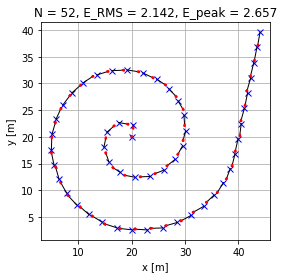

In [34]:
# Ploteo la curva recorrida del robot vs la curva deseada
N = trajectory.shape[1]
fig,ax = plt.subplots(1)

# se plotea la curva deseada
ax.plot(trajectory[0,:],trajectory[1,:],'bx',linewidth=1)
#ax.plot(trajectory[0,:],trajectory[1,:],'b-',linewidth=1)
curva_aux = np.array(curva_recorrida)
# se plotea la curva seguida por el robot
# ax.plot(curva_aux[:,0],curva_aux[:,1],'r-',linewidth = 1)
# ax.plot(curva_aux[:,0],curva_aux[:,1],'rx',markersize = 5)

for i in range(0,N):
    ax.plot([trajectory[0,:][i],curva_aux[:,0][i]],[trajectory[1,:][i],curva_aux[:,1][i]],'k',linewidth = 1)

    pose_del_robot = curva_aux[i]

    plotear_robot(ax,pose_del_robot[0],pose_del_robot[1],pose_del_robot[2],robot.diameter/2,'r')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.set_title('N = %i, E_RMS = %.3f, E_peak = %.3f' %(N, E_RMS, E_peak))
ax.grid(True)

# Se agrega texto para agregar información

In [35]:
# Celda para guardar el gráfico de la curva en una imagen
fig.savefig('NO_DNN.png',dpi = 300)

In [ ]:
np.linalg.norm(trajectory[:,39] - curva_recorrida[38][0:2])

19.601845937938414

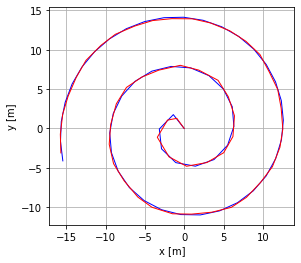

In [ ]:
# Gráfico de la curva recorrida vs curva deseada

fig, ax = plt.subplots(1)

ax.plot(trajectory[0,:],trajectory[1,:],'b-',linewidth=1)
ax.plot(curva_aux[:,0],curva_aux[:,1],'r-',linewidth = 1)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect('equal')
ax.grid(True)

In [ ]:
fig.savefig('test.png',dpi = 300)

In [ ]:
print(robot.get_simulation_time_mobile_robot())
print(robot.get_simulation_time_control())

Se exportan los datos de las trayectorias real y deseada, para luego realizar el entrenamiento de la red neuronal.

In [37]:
# Td es la trayectoria deseada
Td = trajectory

# Tr contiene los estados reales que fue recorriendo el robot
Tr = np.array(curva_recorrida)
Tr = np.transpose(Tr)

# cantidad de estados en las trayectorias
N = Tr.shape[1]

# Se guardan los datos de la trayectoria
np.savez("trayectorias_ref_deseada",Tr,Td)

In [ ]:
robot.stop_simulation()

Robot: simulation stopped
Control: simulation stopped
